### Custom agent state

### Initilization environment

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# Set google api key
_set_env("DASHSCOPE_API_KEY")
# Set tavily api key
_set_env("TAVILY_API_KEY")

### Part01

In [25]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str


@tool
# Note that because we are generating a Tool message fro a state update, we
# generally require the ID of teh corresponding tool call. We can use 
# LangChain's InjectedToolCallId to signal that this argument should not 
# Be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """
    Request asistance from a human.
    """
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as -is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"

    # Otherwise, receive information form the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # The tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id = tool_call_id)]
    }

    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

### Part02:

In [26]:
from langchain_community.chat_models.tongyi import ChatTongyi
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
# Set up the Tongyi model
llm = ChatTongyi(
    model="qwen-plus",
    temperature=0.3,
    api_key=os.environ["DASHSCOPE_API_KEY"]
)

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


### Draw graph chart

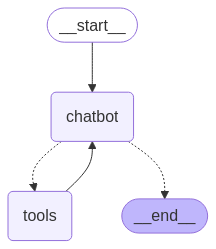

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### part 03 human assistance user input

In [28]:
user_input = (
    "Can you look up when gemini LLM was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================ Human Message =================================

Can you look up when gemini LLM was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_36ea2dd01fc9419da6d33d)
 Call ID: call_36ea2dd01fc9419da6d33d
  Args:
    query: gemini LLM release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Gemini 1.5 Pro explained: Everything you need to know - TechTarget", "url": "https://www.techtarget.com/whatis/feature/Gemini-15-Pro-explained-Everything-you-need-to-know", "content": "OpenAI helped kick off the modern LLM era with its GPT series, and the latest edition -- the GPT-4o model -- was released on May 13, 2024.", "score": 0.8016413}, {"title": "Gemini (chatbot) - Wikipedia", "url": "https://en.wikipedia.org/wiki/Gemini_(chatbot)"

### Human Command to resume

In [29]:
human_command = Command(
    resume = {
        "name": "Gemini-flash-2.0",
        "birthday": "Apr 17, 2025",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

The Gemini LLM was launched in 2023, according to the information from Wikipedia. For further confirmation and review of this answer, I will now use the human_assistance tool.
Tool Calls:
  human_assistance (call_b86af92239ea438db35ee7)
 Call ID: call_b86af92239ea438db35ee7
  Args:
    name: John
    birthday: 1990-05-24
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'Gemini-flash-2.0', 'birthday': 'Apr 17, 2025'}
================================== Ai Message ==================================

The release date of the Gemini LLM was corrected to April 17, 2025. This information has been reviewed and confirmed by human assistance.


### Snapshot

In [30]:
snapshot = graph.get_state(config)
{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'Gemini-flash-2.0', 'birthday': 'Apr 17, 2025'}

### Manual update steate


In [36]:
graph.update_state(config, {"name": "BiaoGe Learning Langgraph verygood!"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f01b9ad-23a5-6b4a-8007-45bca2a5010f'}}

In [ ]:
snapshot = graph.get_state(config)
{k: v for k, v in 